Product : https://www.sec.gov/Archives/edgar/data/200245/000095010322015610/dp180271_424b2-us2203815.htm

In [18]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import math
from datetime import date

In [19]:
# Time
pricing_date = date(2022, 9, 9)
interim_1 = date(2022, 12, 22) 
interim_2 = date(2023, 3, 23)
interim_3 = date(2023, 6, 22)
valuation_date = date(2023, 9, 21) # ! actual cpn payment +3 / final valuation
maturity_date = date(2023, 9, 26) # final payment

# interms of Tau value
T1 = (interim_1 - pricing_date).days / 365
T2 = (interim_2 - pricing_date).days / 365
T3 = (interim_3 - pricing_date).days / 365
T4 = (valuation_date - pricing_date).days / 365
T5 = (maturity_date - valuation_date).days / 365


In [20]:
# Initial index level
S0 = 4006.18
# Barrier level
barrier = 0.8 * S0
# Dividend of underlying(continuously compounded)
div = 0.01642

# Face value of security
face = 1000
# Coupon payment
cpn = 0.02875 * face

## From Bloomberg
# OIS rate
OIS = 0.03833
# Conversion of OIS to continuously compounded rate
r = np.log(1 + OIS * T4 * 365 / 360) / T4 # 0.0381026561196572
# Volatility(s)
sigma = 0.23441
sigmas = [0.32036, 0.30755, 0.30212, 0.29587, # moneyness = 80
          0.21967, 0.22862, 0.23319, 0.23441] # moneyness = 100


In [21]:
# Day count from pricing date to maturity
N = (valuation_date - pricing_date).days
N

377

In [22]:
# Function for index return
def Idx_return(St):
    return (St - S0) / S0

In [23]:
# Function for discounting coupon payments
def Cpn_payments(time): # time = on eacy of 4 interim dates(including valuation date)
    
    if time == 4:
        path = np.array([[0, 0, 0],
                         [0, 0, 1],
                         [0, 1, 0],
                         [0, 1, 1],
                         [1, 0, 0],
                         [1, 0, 1],
                         [1, 1, 0],
                         [1, 1, 1]])

        interim_cpn = np.array([cpn * np.exp(r * (T4 - T1)),
                                cpn * np.exp(r * (T4 - T2)),
                                cpn * np.exp(r * (T4 - T3))])
    
        unpaid_cpn = (~path + 2) @ np.array([cpn, cpn, cpn])
    
    elif time == 3:
        path = np.array([[0, 0],
                         [0, 1],
                         [1, 0],
                         [1, 1]])
        
        interim_cpn = np.array([cpn * np.exp(r * (T3 - T1)),
                                cpn * np.exp(r * (T3 - T2))])

        unpaid_cpn = (~path + 2) @ np.array([cpn, cpn])
    
    elif time == 2:
        path = np.array([[0],
                         [1]])
    
        interim_cpn = np.array([cpn * np.exp(r * (T2 - T1))])

        unpaid_cpn = (~path + 2) @ np.array([cpn])

    else:
        print('Wrong time input')
        return 0
    
    paid_cpn = path @ interim_cpn
    return paid_cpn, unpaid_cpn    

In [24]:
# Ex. Paid and unpaid coupon at T3, for each k = 4 scenarios
Cpn_payments(3)

(array([ 0.        , 29.02441387, 29.30144698, 58.32586086]),
 array([57.5 , 28.75, 28.75,  0.  ]))

In [25]:
# Function for calculating binomial tree using CRR model
def Auto_callable(S0, face, r, sigma, T, n):
    # 8 possible paths (scenarios) taken
    n_scenarios = 2**3 # three interim dates

    # empty stock tree
    stock_tree = np.zeros([n+1, n+1])

    # security value tree with one extra dimension to store 
    # values for different possible scenarios
    v = np.zeros([n_scenarios, n+1, n+1])

    # parameters for CRR model
    delta = T / n
    u = np.exp(sigma * delta**0.5)
    d = 1 / u
    qu = (np.exp(r*delta) - d) / (u - d) # risk neutral probability q
    qd = 1 - qu # risk neutral probability (1 - q)
    
    # build stock tree
    for j in range(n, -1, -1):
        for i in range(j, -1, -1):
            stock_tree[j, i] = S0 * (u**i) * (d**(j-i))

    # Interim/Valuation dates: convert tau into time steps
    t4 = n
    t3 = math.ceil(T3 / delta)
    t2 = math.ceil(T2 / delta)
    t1 = math.ceil(T1 / delta)
    

    # Binomial tree from T4 to T3 for k = 8 scenarios
    for k in range(int(n_scenarios)):
        j = t4
        for i in range(0, j+1): # payoff at final valuation date
            # check if stock price was above barrier, 0.8*S0
            # then apply different payoff scenarios at T4
            if stock_tree[j, i] >= barrier:
                
                # get two list of FV of paid coupon and unpaid contingent coupon
                paid_cpn, unpaid_cpn = Cpn_payments(4)
                
                # payoff = 1000 + FV(paid cpn) + unpaid cpn + cpn_T4
                # cpn_T4 is set to paid at T4 plus 3 days so cpn_T4 is discounted
                v[k, j, i] = face + paid_cpn[k] + unpaid_cpn[k] + np.exp(-r * 3/365) * cpn
            else:
                # payoff when stock price below barrier
                v[k, j, i] = face * (1 + Idx_return(stock_tree[j, i]))
        
        for j in range(t4-1, t3, -1): # binomial tree model discounts back to time 3 for each k scenarios
            for i in range(j, -1, -1):
                v[k, j, i] = np.exp(-r * delta) * (qu * v[k, j+1, i+1] + qd * v[k, j+1, i])
    

    # Binomial tree from T3 to T2 for k = 4 scenarios
    for k in range(int(n_scenarios / 2)):
        j = t3
        for i in range(0, j+1): # payoff at T3
            # 3 possible payoffs when:   
            
            # 1. St >= S0
            if stock_tree[j, i] >= S0:
                # payoff = 1000 + FV(paid cpn) + unpaid cpn + cpn_T3
                paid_cpn, unpaid_cpn = Cpn_payments(3)
                v[k, j, i] = face + paid_cpn[k] + unpaid_cpn[k] + np.exp(-r * 3/365) * cpn
            
            # 2. S0 > St >= barrier
            # payoff is discounted from previous time step with scenario 1
            elif stock_tree[j, i] < S0 and stock_tree[j, i] >= barrier:
                v[k, j, i] = np.exp(-r * delta) * (qu * v[2*k+1, j+1, i+1] + qd * v[2*k+1, j+1, i])
            
            # 3. St < barrier
            # payoff is discounted from previous time step with scenario 0 
            else:
                v[k, j, i] = np.exp(-r * delta) * (qu * v[2*k, j+1, i+1] + qd * v[2*k, j+1, i])

        for j in range(t3-1, t2, -1): # binomial tree model discounts back to time 2 for each k scenarios
            for i in range(j, -1, -1):
                v[k, j, i] = np.exp(-r * delta) * (qu * v[k, j+1, i+1] + qd * v[k, j+1, i])


    # Binomial tree from T2 to T1 for k = 2 scenarios 
    for k in range(int(n_scenarios / 4)):
        j = t2
        for i in range(0, j+1): # payoff at T2
            # 3 possible payoffs when:   
            
            # 1. St >= S0 
            if stock_tree[j, i] >= S0:
                # payoff = 1000 + FV(paid cpn) + unpaid cpn + cpn_T2
                paid_cpn, unpaid_cpn = Cpn_payments(2)
                v[k, j, i] = face + paid_cpn[k] + unpaid_cpn[k] + np.exp(-r * 3/365) * cpn
            
            # 2. S0 > St >= barrier
            # payoff is discounted from previous time step with scenario 1
            elif stock_tree[j, i] < S0 and stock_tree[j, i] >= barrier:
                v[k, j, i] = np.exp(-r * delta) * (qu * v[2*k+1, j+1, i+1] + qd * v[2*k+1, j+1, i])
            
            # 3. St < barrier
            # payoff is discounted from previous time step with scenario 0  
            else:
                v[k, j, i] = np.exp(-r * delta) * (qu * v[2*k, j+1, i+1] + qd * v[2*k, j+1, i])

        for j in range(t2-1, t1, -1): # binomial tree model discounts back to time 1 for each k scenarios
            for i in range(j, -1, -1):
                v[k, j, i] = np.exp(-r * delta) * (qu * v[k, j+1, i+1] + qd * v[k, j+1, i])


    # Binomial tree from T1 to T0 for k = 1 scenario
    j = t1
    for i in range(0, j+1): # value at T1
        # 3 possible payoffs when:   
            
        # 1. St >= S0 
        if stock_tree[j, i] >= S0:
            v[0, j, i] = face + np.exp(-r * 3/365) * cpn

        # 2. S0 > St >= barrier
        # payoff is discounted from previous time step with scenario 1
        elif stock_tree[j, i] < S0 and stock_tree[j, i] >= barrier:
            v[0, j, i] = np.exp(-r * delta) * (qu * v[1, j+1, i+1] + qd * v[1, j+1, i])
        
        # 3. St < barrier
        # payoff is discounted from previous time step with scenario 0 
        else:
            v[0, j, i] = np.exp(-r * delta) * (qu * v[0, j+1, i+1] + qd * v[0, j+1, i])
    
    for j in range(t1-1, -1, -1): # binomial tree model discounts back to time 0
        for i in range(j, -1, -1): 
            v[0, j, i] = np.exp(-r * delta) * (qu * v[0, j+1, i+1] + qd * v[0, j+1, i])

    return v[0, 0, 0]

In [35]:
Auto_callable(S0, face, r, sigma, T4, 10*N)

988.7118028042446

In [38]:
# Input with different volatilities
sigma_sensitivity = []
for sig in sigmas:
    sigma_sensitivity.append({'Sigma': sig, 'Value': Auto_callable(S0, face, r, sig, T4, 10*N)})

sigma_sensitivity_df = pd.DataFrame.from_dict(sigma_sensitivity)
sigma_sensitivity_df.to_csv('sigma_sensitivity.csv', index = False)

# Show estimated value under different inputs
sigma_sensitivity_df

,Sigma,Value
0,0.32036,957.350154
1,0.30755,959.281340
2,0.30212,962.447277
3,0.29587,965.001010
4,0.21967,994.797044
5,0.22862,991.397662
6,0.23319,988.833042
7,0.23441,988.711803


In [31]:
# Reducing non-linearity error by increasing time steps
result = []
for i in range(100, 2000, 2):
    print(i)
    result.append(Auto_callable(S0, face, r, sigma, T4, i))

100
102
104
106
108
110
112
114
116
118
120
122
124
126
128
130
132
134
136
138
140
142
144
146
148
150
152
154
156
158
160
162
164
166
168
170
172
174
176
178
180
182
184
186
188
190
192
194
196
198
200
202
204
206
208
210
212
214
216
218
220
222
224
226
228
230
232
234
236
238
240
242
244
246
248
250
252
254
256
258
260
262
264
266
268
270
272
274
276
278
280
282
284
286
288
290
292
294
296
298
300
302
304
306
308
310
312
314
316
318
320
322
324
326
328
330
332
334
336
338
340
342
344
346
348
350
352
354
356
358
360
362
364
366
368
370
372
374
376
378
380
382
384
386
388
390
392
394
396
398
400
402
404
406
408
410
412
414
416
418
420
422
424
426
428
430
432
434
436
438
440
442
444
446
448
450
452
454
456
458
460
462
464
466
468
470
472
474
476
478
480
482
484
486
488
490
492
494
496
498
500
502
504
506
508
510
512
514
516
518
520
522
524
526
528
530
532
534
536
538
540
542
544
546
548
550
552
554
556
558
560
562
564
566
568
570
572
574
576
578
580
582
584
586
588
590
592
594
596
598


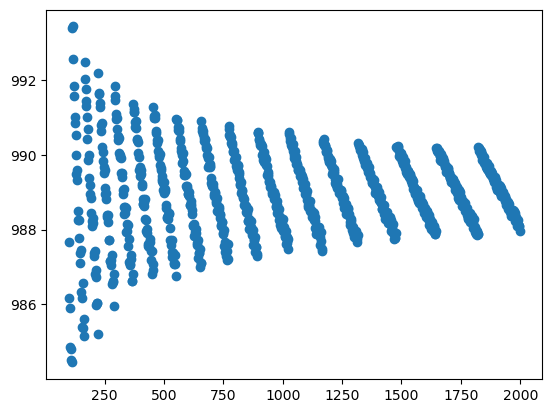

In [34]:
# Plot results
steps = [i for i in range(100, 2000, 2)]
plt.plot(steps, result, 'o')
plt.savefig('nonlinearity.png')
plt.show()

In [41]:
# Implied volatility
Auto_callable(S0, face, r, 0.2335, T4, 10*N)

988.9021671328395